# The Internet: Behind the Scenes

The Internet is a transport mechanism that lets any connected device communicate with any other connected device. Behind the scenes:

    Each device has a globally distinct IP address, which is a 32 bit number. Usually an IP address is represented as a sequence of four decimal numbers, each number in the range (0, 255). For example, when I checked the IP address for my laptop just now, it was 141.211.203.248. Any IP address beginning with 141.211 is for a device at the University of Michigan. When I take my laptop home and connect to a network there, my laptop gets a different IP address that it uses there.

    Data is chopped up into reasonable sized packets (up to 65,535 bytes, but usually much smaller).

    Each data packet has a header that includes the destination IP address.

    Each packet is routed independently, getting passed on from one computing device to another until it reaches its destination. The computing devices that do that packet forwarding are called routers. Each router keeps an address table that says, when it gets a packet for some destination address, which of its neighbors should it pass the packet on to. The routers are constantly talking to each other passing information about how they should update their routing tables. The system was designed to be resistant to any local damage. If some of the routers stop working, the rest of the routers talk to each other and start routing packets around in a different way so that packets still reach their intended destination if there is some path to get there. It is this technical capability that has spawned metaphoric quotes like this one from John Gilmore: “The Net interprets censorship as damage and routes around it.”

    At the destination, the packets are reassembled into the original data message.


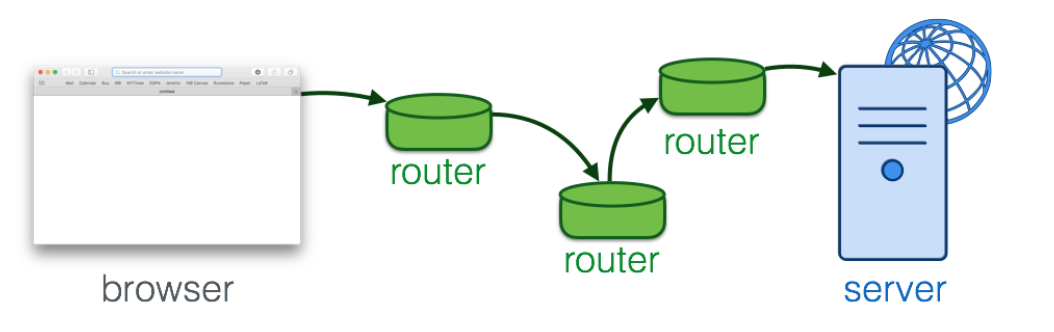

# Anatomy of URLs

A URL is used by a browser or other program to specify what server to connect to and what page to ask for. Like other things that will be interpreted by computer programs, URLs have a very specific formal structure. If you put a colon in the wrong place, the URL won’t work correctly. The overall structure of a URL is:
```
<scheme>://<host>:<port>/<path>
```
Usually, the scheme will be http or https. The s in https stands for “secure”. When you use https, all of the communication between the two devices is encrypted. Any devices that intercepts some of the packets along the way will be unable to decrypt the contents and figure out what the data was.

Other schemes that you will sometimes see include ftp (for file transfer) and mailto (for email addresses).

The host will usually be a domain name, like si.umich.edu or github.com or google.com. When the URL specifies a domain name, the first thing the computer program does is look up the domain name to find the 32-bit IP address. For example, right now the IP adddress for github.com is 192.30.252.130. This could change if, for example, github moved its servers to a different location or contracted with a different Internet provider. Lookups use something called the Domain Name System, or DNS for short. Changes to the mapping from domain names to IP addresses can take a little while to propagate: if github.com announces a new IP address associated with its domain, it might take up to 24 hours for some computers to start translating github.com to the new IP address.

Alternatively, the host can be an IP address directly. This is less common, because IP addresses are harder to remember and because a URL containing a domain name will continue to work even if the remote server keeps its domain name but moves to a different IP address.

The :port is optional. If it is omitted, the default port number is 80. The port number is used on the receiving end to decide which computer program should get the data that has been received. We probably will not encounter any URLs that include the : and a port number in this course.

The /path is also optional. It specifies something about which page, or more generally which contents, are being requested.

For example, consider the url https://github.com/presnick/runestone:

    https:// says to use the secure http protocol

    github.com says to connect to the server at github.com, which currently maps to the IP address 192.30.252.130. The connection will be made on the default port, which is 443 for https.

    /presnick/runestone says to ask the remote server for the page presnick/runestone. It is up to the remote server to decide how to map that to the contents of a file it has access to, or to some content that it generates on the fly.

The url http://blueserver.com/path?k=val is another example that we can consider. The path here a bit different from https://github.com/presnick/runestone because it includes what are called “query parameters”, the information after the ?.
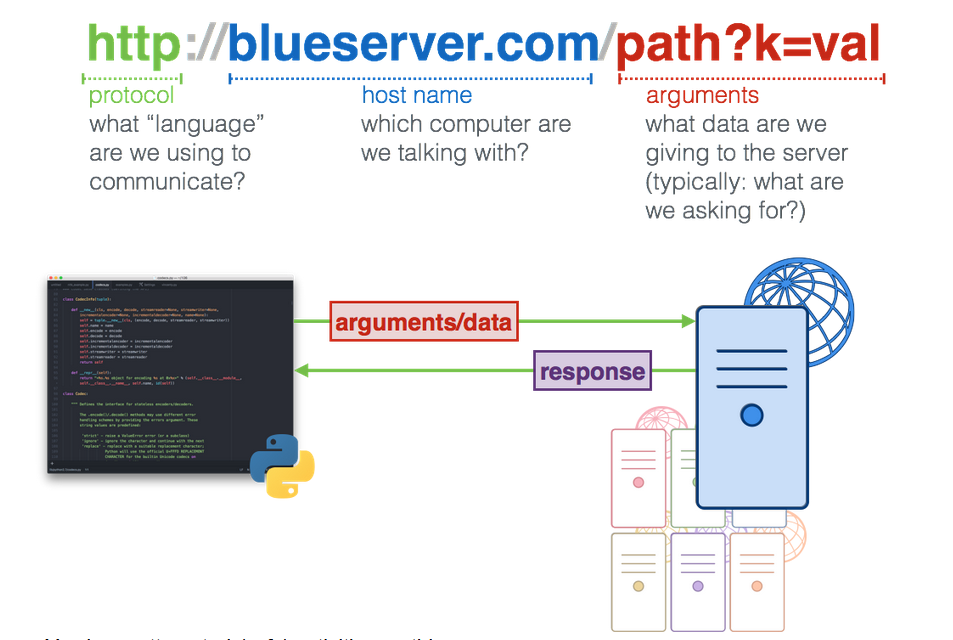

# The HTTP protocol

A protocol specifies the order in which parties will speak and the format of what they say and the content of appropriate responses.

HTTP is the protocol that specifies how web browsers or other programs communicate with web servers. One version of the formal specification, before it was later split into multiple documents, was IETF RFC 2616. It is 176 pages long! Fortunately, the basics are pretty easy to understand.

    Step 1: the client makes a request to the server.

            If the request only involves fetching data, the client sends a message of the form GET <path>, where <path> is the path part of the URL

            If the request involves sending some data (e.g., a file upload, or some authentication information), the message starts with POST

            In either case, the client sends some HTTP headers. These include:

                    The type of client program. This allows the server to send back different things to small mobile devices than desktop browsers (a “responsive” website)

                    Any cookies that the server previously asked the client to hold onto. This allows the server to continue previous interactions, rather than treating every request as stand-alone. It also allows ad networks to place personalized ads.

            After the HTTP headers, for a POST type communication, there is some data (the body of the request).


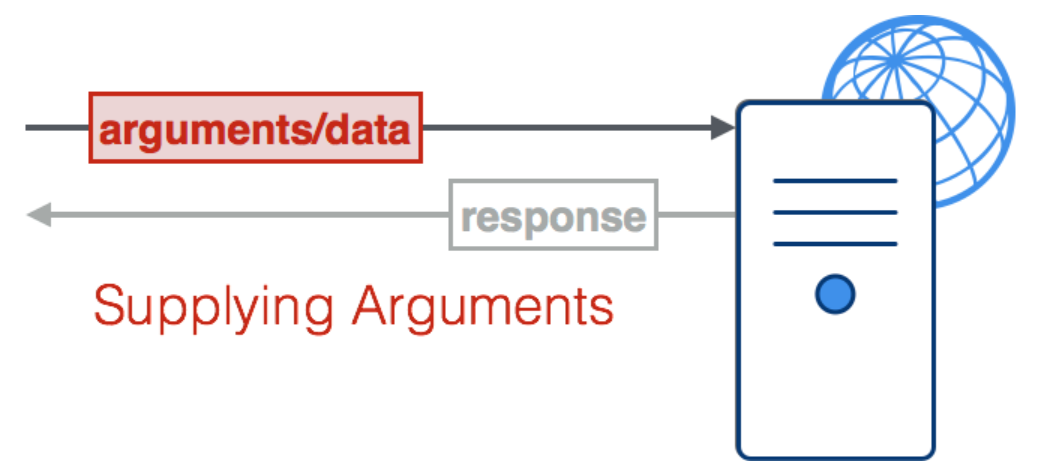



    Step 2: the server responds to the client.

            The server first sends back some HTTP headers. These include:

                    a response code indicating whether the server thinks it has fulfilled the request or not.

                    a description of the type of content it is sending back (e.g., text/html when it is sending html-formatted text).

                    any cookies it would like the client to hold onto and send back the next time it communicates with the server.

            After the headers come the contents. This is the stuff that you would see if you ask to “View Source” in a browser.

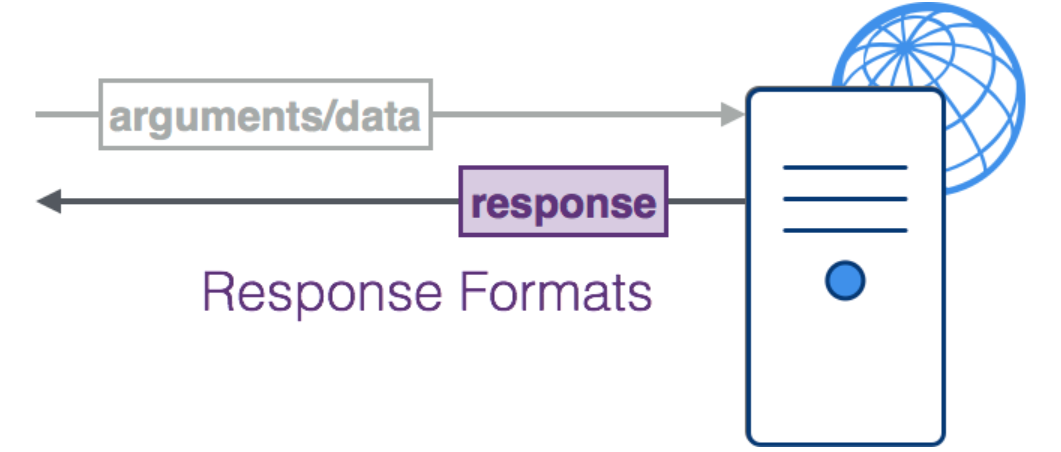

# Using REST APIs

REST stands for REpresentational State Transfer. It originally had a more abstract meaning, but has come to be a shorthand name for web sites that act a bit like python functions, taking as inputs values for certain parameters and producing outputs in the form of a long text string.

API stands for Application Programming Interface. An API specifies how an external program (an application program) can request that a program perform certain computations.

Putting the two together, a REST API specifies how external programs can make HTTP requests to a web site in order to request that some computation be carried out and data returned as output. When a website is designed to accept requests generated by other computer programs, and produce outputs to be consumed by other programs, it is sometimes called a web service, as opposed to a web site which produces output meant for humans to consume in a web browser.

Of course, a web browser is just a computer program, so all requests to web sites come from other computer programs. But usually a browser requests data from a web site in order to display it directly to a human user of the browser.

Prior to the development of REST APIs, there were other ways that computer programs made remote requests to other computers on a network, asking them to perform some computation or retrieve some data. Those other techniques are still in use. REST APIs are particularly convenient, however, both for students and for others, because it is easy to see what is going on in a request and a response between two computers, and thus it is easier to debug.

We will examine a common pattern used in REST APIs, where there is a base URL that defines an “endpoint”, and then additional information is appended to the URL as query parameters, and the response comes back not as HTML but as a format called JSON. Along the way, we will see some functions in python modules that are helpful for constructing the URLS and for processing the JSON formatted response.
24.5.1. URL Structure for REST APIs

In a REST API, the client or application program– the kind of program you will be writing– makes an HTTP request that includes information about what kind of request it is making. Web sites are free to define whatever format they want for how the request should be formatted. This chapter covers a particularly common and particularly simple format, where the request information is encoded right in the URL. This is convenient, because if something goes wrong, we can debug by copying the URL into a browser and see what happens when it tries to visit that URL.

In this format, the URL has a standard structure:

    the base URL

    a ? character

    one or more key-value pairs, formatted as key=value pairs and separated by the & character.

For example, consider the URL https://itunes.apple.com/search?term=Ann+Arbor&entity=podcast. Try copying that URL into a browser, or just clicking on it. It retrieves data about podcasts posted from Ann Arbor, MI. Depending on your browser, it may put the contents into a file attachment that you have to open up to see the contents, or it may just show the contents in a browser window.

Let’s pull apart that URL.

    the base URL: https://itunes.apple.com/search

    a ? character

    key=value pairs. In this case, there are two pairs. The keys are term and entity. An & separates the two pairs.


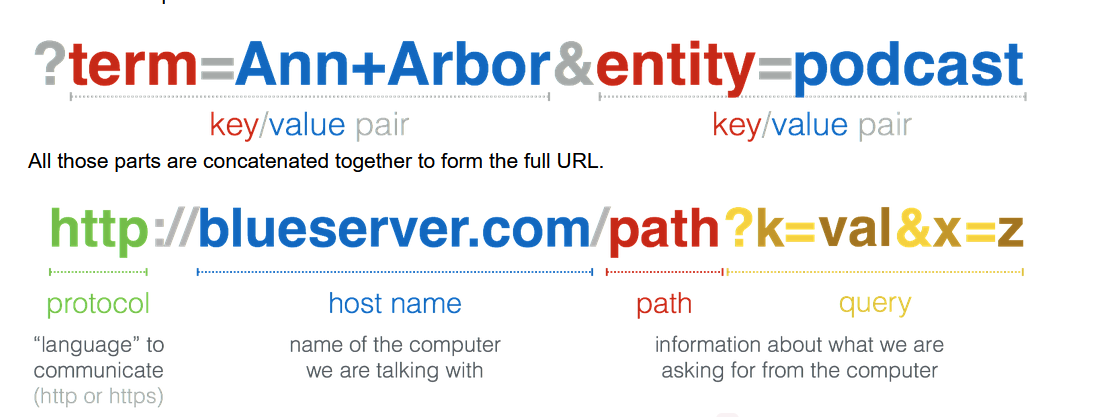

Note that in the search term Ann Arbor, the space had to be “encoded” as +. More on that below.
24.5.2. Encoding URL Parameters

Here’s another URL that has a similar format. https://www.google.com/search?q=%22violins+and+guitars%22&tbm=isch. It’s a search on Google for images that match the string “violins and guitars”. It’s not actually based on a REST API, because the contents that come back are meant to be displayed in a browser. But the URL has the same structure we have been exploring above and introduces the idea of “encoding” URL parameters.

    The base URL is https://www.google.com/search

    ?

    Two key=value parameters, separated by &

            q=%22violins+and+guitars%22 says that the query to search for is “violins and guitars”.

            tbm=isch says to go to the tab for image search

Now why is "violins and guitars" represented in the URL as %22violins+and+guitars%22? The answer is that some characters are not safe to include, as is, in URLs. For example, a URL path is not allowed to include the double -quote character. It also can’t include a : or / or a space. Whenever we want to include one of those characters in a URL, we have to encode them with other characters. A space is encoded as +. " is encoded as %22. : would be encoded as %3A. And so on.


# Fetching a page

In [1]:
import requests
import json

page = requests.get("https://api.datamuse.com/words?rel_rhy=funny")
print(type(page))
print(page.text[:150]) # print the first 150 characters
print(page.url) # print the url that was fetched
print("------")
x = page.json() # =json.loads(page.text) turn page.text into a python object
print(type(x))
print("---first item in the list---")
print(x[0])
print("---the whole list, pretty printed---")
print(json.dumps(x, indent=2)) # pretty print the results

<class 'requests.models.Response'>
[{"word":"money","score":4415,"numSyllables":2},{"word":"honey","score":1206,"numSyllables":2},{"word":"sunny","score":717,"numSyllables":2},{"word":"
https://api.datamuse.com/words?rel_rhy=funny
------
<class 'list'>
---first item in the list---
{'word': 'money', 'score': 4415, 'numSyllables': 2}
---the whole list, pretty printed---
[
  {
    "word": "money",
    "score": 4415,
    "numSyllables": 2
  },
  {
    "word": "honey",
    "score": 1206,
    "numSyllables": 2
  },
  {
    "word": "sunny",
    "score": 717,
    "numSyllables": 2
  },
  {
    "word": "bunny",
    "score": 702,
    "numSyllables": 2
  },
  {
    "word": "blini",
    "score": 613,
    "numSyllables": 2
  },
  {
    "word": "gunny",
    "score": 449,
    "numSyllables": 2
  },
  {
    "word": "tunny",
    "score": 301,
    "numSyllables": 2
  },
  {
    "word": "sonny",
    "score": 286,
    "numSyllables": 2
  },
  {
    "word": "dunny",
    "score": 245,
    "numSyllables": 2


## More Details of Response objects

Once we run requests.get, a python object is returned. It’s an instance of a class called Response that is defined in the requests module. We won’t look at it’s definition. Think of it as analogous to the Turtle class. Each instance of the class has some attributes; different instances have different values for the same attribute. All instances can also invoke certain methods that are defined for the class.

In the Runestone environment, we have a very limited version of the requests module available. The Response object has only two attributes that are set, and one method that can be invoked.

    The .text attribute. It contains the contents of the file or other information available from the url (or sometimes an error message).

    The .url attribute. We will see later that requests.get takes an optional second parameter that is used to add some characters to the end of the base url that is the first parameter. The .url attribute displays the full url that was generated from the input parameters. It can be helpful for debugging purposes; you can print out the URL, paste it into a browser, and see exactly what was returned.

    The .json() method. This converts the text into a python list or dictionary, by passing the contents of the .text attribute to the jsons.loads function.

The full Requests module provides some additional attributes in the Response object. These are not implemented in the Runestone environment.

    The .status_code attribute.

        When a server thinks that it is sending back what was requested, it sends the code 200.

        When the requested page doesn’t exist, it sends back code 404, which is sometimes described as “File Not Found”.

        When the page has moved to a different location, it sends back code 301 and a different URL where the client is supposed to retrieve from. In the full implementation of the requests module, the get function is so smart that when it gets a 301, it looks at the new url and fetches it. For example, github redirects all requests using http to the corresponding page using https (the secure http protocol). Thus, when we ask for http://github.com/presnick/runestone, github sends back a 301 code and the url https://github.com/presnick/runestone. The requests.get function then fetches the other url. It reports a status of 200 and the updated url. We have to do further inquire to find out that a redirection occurred (see below).

    The .headers attribute has as its value a dictionary consisting of keys and values. To find out all the headers, you can run the code and add a statement print(p.headers.keys()). One of the headers is ‘Content-type’. Some possible values are text/html; charset-utf-8 and application/json; charset=utf-8.

    The .history attribute contains a list of previous responses, if there were redirects.

To summarize, a Response object, in the full implementation of the requests module has the following useful attributes that can be accessed in your program:

    .text

    .url

    .json()

    .status_code (not available in Runestone implementation)

    .headers (not available in Runestone implementation)

    .history (not available in Runestone implementation)


# Using requests.get to encode URL parameters

Fortunately, when you want to pass information as a URL parameter value, you don’t have to remember all the substitutions that are required to encode special characters. Instead, that capability is built into the requests module.

The get function in the requests module takes an optional parameter called params. If a value is specified for that parameter, it should be a dictionary. The keys and values in that dictionary are used to append something to the URL that is requested from the remote site.

For example, in the following, the base url is https://google.com/search. A dictionary with two parameters is passed. Thus, the whole url is that base url, plus a question mark, “?”, plus a “q=…” and a “tbm=…” separated by an “&”. In other words, the final url that is visited is https://www.google.com/search?q=%22violins+and+guitars%22&tbm=isch. Actually, because dictionary keys are unordered in python, the final url might sometimes have the encoded key-value pairs in the other order: https://www.google.com/search?tbm=isch&q=%22violins+and+guitars%22. Fortunately, most websites that accept URL parameters in this form will accept the key-value pairs in any order.
```
d = {'q': '"violins and guitars"', 'tbm': 'isch'}
results = requests.get("https://google.com/search", params=d)
print(results.url)
```
Below are more examples of urls, outlining the base part of the url - which would be the first argument when calling request.get() - and the parameters - which would be written as a dictionary and passed into the params argument when calling request.get().

In [2]:
import requests

# page = requests.get("https://api.datamuse.com/words?rel_rhy=funny")
kval_pairs = {'rel_rhy': 'funny'}
page = requests.get("https://api.datamuse.com/words", params=kval_pairs)
print(page.text[:150]) # print the first 150 characters
print(page.url) # print the url that was fetched


[{"word":"money","score":4415,"numSyllables":2},{"word":"honey","score":1206,"numSyllables":2},{"word":"sunny","score":717,"numSyllables":2},{"word":"
https://api.datamuse.com/words?rel_rhy=funny


# Figuring Out How to Use a REST API

Suppose you have learned about the existence of an API, and want to figure out how to use it. There are five questions that you’ll need to answer.

    What is the baseurl?

    What keys should you provide in the dictionary you pass for the params parameter?

    What values should you provide associated with those keys?

    Do you need to authenticate yourself as a licensed user of the API and, if so, how?

    What is the structure and meaning of the data that will be provided?

The answers to these questions always depend on design choices made by the service provider who is running the server. Thus, the official documentation they provide will usually be the most helpful. It may also be helpful to find example code snippets or full URLs and responses; if you don’t find that in the documentation, you may want to search for it on Google or StackOverflow.

## Example: the datamuse API

Consider the datamuse API. Click on that link to open the webpage, which provides documentation. You have already seen an example of a full URL, https://api.datamuse.com/words?rel_rhy=funny. Let’s work through the documentation to answer the five questions.

First, in the section titled, “What is it good for?” there is a column header titled,”…use https://api.datamuse.com…”. That specifies the first part of the URL: “https://api.datamuse.com/”. However, all of the examples also include some additional characters after the / and before the ?: either words or sug. These are called endpoints. Thus, the baseurl will be one of the two endpoints, either https://api.datamuse.com/words or https://api.datamuse.com/sug.

The answers to questions two and three, about the contents of the value of the params dictionary, can be found in the section of the documentation that describes the particular endpoint. For example, take a look at the documentation for the “words” endpoint. The entire request will return some words, and all of the params contents will specify constraints that restrict the search. If the url includes ml=funny, then all the words that will be returned will “have a meaning related to” to the word funny. If the url includes rel_cns=book, then all the words returned will have “Consonant match” to “book”. It’s not clear exactly what that means, but it includes words like bike and back: you can try it by visiting https://api.datamuse.com/words?rel_cns=book

The words to the left of the =, like ml and rel_cns and rel_rhy, will be keys in the dictionary that you pass as the value of params in the call to requests.get. The values associated with those keys will be words, like book and funny.

Many providers of APIs require you to register in advance to make use of an API, and then authenticate yourself with each request. That way they can charge money, or restrict usage in some way. A popular form of authentication is to have a personal “api_key” that you pass as one of the key=value pairs in the URL. For example, the flickr API requires that, as we will see later in this chapter. Some services, such as Facebook and Twitter, require an even more complex, and secure, form of authentication, where a credential is used to cryptographically sign requests. We will not cover the use of that more complex authentication, as it is considerably harder to debug.

Currently, datamuse does not require any authentication. You can tell that because, in the section titled “Usage limits”, it states, “You can use this service without restriction and without an API key for up to 100,000 requests per day. Please be aware that beyond that limit, keyless requests may be rate-limited without notice. If you’d like to use this in a customer-facing application, or if you need a custom vocabulary, or if you plan to make more than 100,000 requests per day, you can get an API key and a stable version to use with a greater availability guarantee.”

Finally, the datamuse documentation provides a section “Interpreting the results” that explains what kind of data will be returned by the API. In this case, the structure is quite simple, it is a JSON-formatted list of dictionaries, where each dictionary provides a single word that satisfies the hard constraints in the query, and a score saying how good a match it is on the soft constraints.

## Defining a function to make repeated invocations

Suppose you were writing a computer program that was going to automatically translate paragraphs of text into paragraphs with similar meanings but with more rhymes. You would want to contact the datamuse API repeatedly, passing different values associated with the key rel_rhy. Let’s make a python function to do that. You can think of it as a wrapper for the call to requests.get.

In [4]:
# import statements for necessary Python modules
import requests

def get_rhymes(word):
    baseurl = "https://api.datamuse.com/words"
    params_diction = {} # Set up an empty dictionary for query parameters
    params_diction["rel_rhy"] = word
    params_diction["max"] = "3" # get at most 3 results
    resp = requests.get(baseurl, params=params_diction)
    # return the top three words
    word_ds = resp.json()
    return [d['word'] for d in word_ds]  ## This one will execute instead of the following code
    return resp.json() # Return a python object (a list of dictionaries in this case)

print(get_rhymes("funny"))


['money', 'honey', 'sunny']


# Debugging calls to requests.get()

## In the Runestone environment

In our limited implementation of the requests library for the Runestone environment, if your request fails for any reason, you will still get a Response object. Most likely, you will realize there was a problem because you invoke the .json() method on the Response object and you get an error that refers to an “unexpected token” in the JSON. When that happens, you should print out the values of the .text and .url attributes.

    If it was unable to use your baseurl and params value to create a url string, the .url attribute will be “Couldn’t generate a valid URL” and the .text attribute will be set to “<html><body><h1>invalid request</h1></body></html>”.

        In that case, you should check that the value you passed for the params parameter is indeed a dictionary and that its keys and values are all strings.

    If it generated a url string but failed to fetch data from the server described by the url string, the .url attribute will be set correctly and the .text attribute will be set to “Failed to retrieve that URL”.

        In that case, you should examine the url to try to figure out what went wrong. In particular, print it, then copy and paste it to a browser window and see what happens.


## In a full python environment

In a full python environment, you will not always get a Response object back from a call to requests.get. What you get back will generally be even more informative than what you get in the Runestone environment, but you have to know where to look.

The first thing that might go wrong is that you get a runtime error when you call requests.get(dest_url). There are two possibilities for what’s gone wrong in that case.

One possibility is that the value provided for the params parameter is not a valid dictionary or doesn’t have key-value pairs that can be converted into text strings suitable for putting into a URL. For example, if you execute requests.get("http://github.com", params = [0,1]), [0,1] is a list rather than a dictionary and the python interpreter generates the error, TypeError: 'int' object is not iterable.

The second possibility is that the variable dest_url is either not bound to a string, or is bound to a string that isn’t a valid URL. For example, it might be bound to the string "http://foo.bar/bat". foo.bar is not a valid domain name that can be resolved to an ip address, so there’s no server to contact. That will yield an error of type requests.exceptions.ConnectionError. Here’s a complete error message:
 ```   
    requests.exceptions.ConnectionError: HTTPConnectionPool(host='foo.bar', port=80): Max retries exceeded with url: /bat?key=val (Caused by <class 'socket.gaierror'>: [Errno 11004] getaddrinfo failed)
   ```
The best approach is to look at the URL that is produced, eyeball it, and plug it into a browser to see what happens. Unfortunately, if the call to requests.get produces an error, you won’t get a Response object, so you’ll need some other way to see what URL was produced. The function defined below takes the same parameters as requests.get and returns the URL as a string, without trying to fetch it.


In [6]:
import requests
def requestURL(baseurl, params = {}):
    # This function accepts a URL path and a params diction as inputs.
    # It calls requests.get() with those inputs,
    # and returns the full URL of the data you want to get.
    req = requests.Request(method = 'GET', url = baseurl, params = params)
    prepped = req.prepare()
    return prepped.url

#print(requestURL(some_base_url, some_params_dictionary))

Assuming requestURL() returns a URL, match up what you see from the printout of the params dictionary to what you see in the URL that was printed out. If you have a sample of a URL from the API documentation, see if the structure of your URL matches what’s there. Perhaps you have misspelled one of the API parameter names or you misspelled the base url.

You can also try cutting and pasting the printed URL into a browser window, to see what error message you get from the website. You can then try changing the URL in the browser and reloading. When you finally get a url that works, you will need to translate the changes you made in the url back into changes to make to your baseurl or params dictionary.

If requests.get() executes without generating a runtime error, you are still not done with your error checking. No error means that your computer managed to connect to some web server and get some kind of response, but it doesn’t mean that it got the data you were hoping to get.

Fortunately, the response object returned by requests.get() has the .url attribute, which will help you with debugging. It’s a good practice during program development to have your program print it out. This is easier than calling requestURL() but is only available to you if requests.get() succeeds in returning a Response object.

More importantly, you’ll want to print out the contents. Sometimes the text that’s retrieved is an error message that you can read, such as {"request empty": "There is no data that corresponds to your search."}. In other cases, it’s just obviously the wrong data. Print out the first couple hundred characters of the response text to see if it makes sense.

In [ ]:
import requests
dest_url = <some expr>
d = <some dictionary>
resp = requests.get(dest_url, params = d)
print(resp.url)
print(resp.text[:200])

Now you try it. Use requests.get() and/or requestURL() to generate the following url, https://www.google.com/search?tbm=isch&q=%22violins+and+guitars%22. (Don’t look at the previous page of the textbook, at least not yet. If you can’t figure it out after 15 minutes of trying the approaches on this page, then look back.)

# Caching Response Content

You haven’t experienced it yet, but if you get complicated data back from a REST API, it may take you many tries to compose and debug code that processes that data in the way that you want. (See the Nested Data chapter.) It is a good practice, for many reasons, not to keep contacting a REST API to re-request the same data every time you run your program.

To avoid re-requesting the same data, we will use a programming pattern known as caching. It works like this:

    Before doing some expensive operation (like calling requests.get to get data from a REST API), check whether you have already saved (“cached”) the results that would be generated by making that request.

    If so, return that same data.

    If not, perform the expensive operation and save (“cache”) the results (e.g. the complicated data) in your cache so you won’t have to perform it again the next time.

If you go on to learn about web development, you’ll find that you encounter caching all the time – if you’ve ever had the experience of seeing old data when you go to a website and thinking, “Huh, that’s weird, it should really be different now… why am I still seeing that?” that happens because the browser has accessed a cached version of the site.

There are at least four reasons why caching is a good idea during your software development using REST APIs:

    It reduces load on the website that is providing you data. It is always nice to be courteous when using other people’s resources. Moreover, some websites impose rate limits: for example, after 15 requests in a 15 minute period, the site may start sending error responses. That will be confusing and annoying for you.

    It will make your program run faster. Connections over the Internet can take a few seconds, or even tens of seconds, if you are requesting a lot of data. It might not seem like much, but debugging is a lot easier when you can make a change in your program, run it, and get an almost instant response.

    It is harder to debug the code that processes complicated data if the content that is coming back can change on each run of your code. It’s amazing to be able to write programs that fetch real-time data like the available iTunes podcasts or the latest tweets from Twitter. But it can be hard to debug that code if you are having problems that only occur on certain Tweets (e.g. those in foreign languages). When you encounter problematic data, it’s helpful if you save a copy and can debug your program working on that saved, static copy of the data.

    It is easier to run automated tests on code that retrieves data if the data can never change, for the same reasons it is helpful for debugging. In fact, we rely on use of cached data in the automated tests that check your code in exercises.

There are some downsides to caching data – for example, if you always want to find out when data has changed, and your default is to rely on already-cached data, then you have a problem. However, when you’re working on developing code that will work, caching is worth the tradeoff. 




# The requests_with_caching module

In [ ]:


In this book, we are providing a special module, called request_with_caching.

Here’s how you’ll use this module.

    Your code will include a statement to import the module, import requests_with_caching.

    Instead of invoking requests.get(), you’ll invoke requests_with_caching.get().

You’ll get exactly the same Response object back that you would have gotten. But you’ll also get a printout in the output window with one of the following three diagnostic messages:

    found in permanent cache

    found in page-specific cache

    new; adding to cache

The permanent cache is contained in a file that is built into the textbook. Your program can use its contents but can’t add to it.

The page-specific cache is a new file that is created the first time you make a request for a url that wasn’t in the permanent cache. Each subsequent request for a new url results in more data being written to the page-specific cache. After you run an activecode that adds something to the page-specific cache, you’ll see a little window below it where you can inspect the contents of the page-specific cache. When you reload the webpage, that page-specific cache will be gone; hence the name.

There are a couple of other optional parameters for the function requests_with_caching.get().

    cache_file– it’s value should be a string specifying the name of the file containing the permanent cache. If you don’t specify anything, the default value is “permanent_cache.txt”. For the datamuse API, we’ve provide a cache in a file called datamuse_cache.txt. It just contains the saved response to the query for “https://api.datamuse.com/words?rel_rhy=funny”.

    private_keys_to_ignore– its value should be a list of strings. These are keys from the parameters dictionary that should be ignored when deciding whether the current request matches a previous request. The main purpose of this is that it allows us to return a result from the cache for some REST APIs that would otherwise require you to provide an API key in order to make a request. By default, it is set to [“api_key”], which is a query parameter used with the flickr API. You should not need to set this optional parameter.

In [3]:
import requests_with_caching
# it's not found in the permanent cache
res = requests_with_caching.get("https://api.datamuse.com/words?rel_rhy=happy", permanent_cache_file="datamuse_cache.txt")
print(res.text[:100])
# this time it will be found in the temporary cache
res = requests_with_caching.get("https://api.datamuse.com/words?rel_rhy=happy", permanent_cache_file="datamuse_cache.txt")
# This one is in the permanent cache.
res = requests_with_caching.get("https://api.datamuse.com/words?rel_rhy=funny", permanent_cache_file="datamuse_cache.txt")


ModuleNotFoundError: No module named 'requests_with_caching'

You may find it useful to understand how this module works. The source code is not very complicated; we’ve reproduced it below. You can use it as a template for implementing code for your own caching pattern in other settings.

Note

This module is not available outside this textbook; in a full python environment you won’t be able to install a requests_with_caching module. But you can copy the code and make it work outside the textbook environment.

Note

We have optimized this code for conceptual simplicity, so that it is useful as a teaching tool. It is not very efficient, because it always stores cached contents in a file, rather than saving it in memory. If you are ever implementing the caching pattern just for the duration of a program’s run, you might want to save cached content in a python dictionary in memory rather than writing it to a file.

The basic idea in the code is to maintain the cache as a dictionary with keys representing API requests that have been made, and values representing the text that was retrieved. In order to make our cache live beyond one program execution, we store it in a file. Hence, there are helper functions _write_to_file and read_to_file that write a cache dictionary to and read it from a file.

In order for the textbook to provide a cache file that can’t be overwritten, we distinguish between the permanent file, which is provided as part of the online textbook, and a temporary cache file that will live only until the page is reloaded.

In [ ]:
import requests
import json

PERMANENT_CACHE_FNAME = "permanent_cache.txt"
TEMP_CACHE_FNAME = "this_page_cache.txt"

def _write_to_file(cache, fname):
    with open(fname, 'w') as outfile:
        outfile.write(json.dumps(cache, indent=2))

def _read_from_file(fname):
    try:
        with open(fname, 'r') as infile:
            res = infile.read()
            return json.loads(res)
    except:
        return {}

def add_to_cache(cache_file, cache_key, cache_value):
    temp_cache = _read_from_file(cache_file)
    temp_cache[cache_key] = cache_value
    _write_to_file(temp_cache, cache_file)

def clear_cache(cache_file=TEMP_CACHE_FNAME):
    _write_to_file({}, cache_file)

def make_cache_key(baseurl, params_d, private_keys=["api_key"]):
    """Makes a long string representing the query.
    Alphabetize the keys from the params dictionary so we get the same order each time.
    Omit keys with private info."""
    alphabetized_keys = sorted(params_d.keys())
    res = []
    for k in alphabetized_keys:
        if k not in private_keys:
            res.append("{}-{}".format(k, params_d[k]))
    return baseurl + "_".join(res)

def get(baseurl, params={}, private_keys_to_ignore=["api_key"], permanent_cache_file=PERMANENT_CACHE_FNAME, temp_cache_file=TEMP_CACHE_FNAME):
    full_url = requests.requestURL(baseurl, params)
    cache_key = make_cache_key(baseurl, params, private_keys_to_ignore)
    # Load the permanent and page-specific caches from files
    permanent_cache = _read_from_file(permanent_cache_file)
    temp_cache = _read_from_file(temp_cache_file)
    if cache_key in temp_cache:
        print("found in temp_cache")
        # make a Response object containing text from the change, and the full_url that would have been fetched
        return requests.Response(temp_cache[cache_key], full_url)
    elif cache_key in permanent_cache:
        print("found in permanent_cache")
        # make a Response object containing text from the change, and the full_url that would have been fetched
        return requests.Response(permanent_cache[cache_key], full_url)
    else:
        print("new; adding to cache")
        # actually request it
        resp = requests.get(baseurl, params)
        # save it
        add_to_cache(temp_cache_file, cache_key, resp.text)
        return resp

In [7]:
int('30%'.strip('%'))

30